<a href="https://colab.research.google.com/github/yello-ow/airbnb_recommend/blob/main/airbnb_recommend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### **선택 데이터 : U.S. Airbnb Open Data (kaggle)**
https://www.kaggle.com/kritikseth/us-airbnb-open-data

###### feature :                   
id                                에어비엔비 고유id (번호)

name                              에어비엔비 이름

host_id                           호스트 고유id (번호)

host_name                         호스트 이름 

neighbourhood_group               주변 그룹

neighbourhood                     동네

latitude                          위도

longitude                         경도

room_type                         에어비엔비 타입 

price                             1박당 에어비엔비 가격

minimum_nights                    최소 숙박 일수

number_of_reviews                 전체 리뷰 수 

last_review                       마지막 리뷰 날짜

reviews_per_month                 월별 평균 리뷰 수

calculated_host_listings_count    호스트의 해당지역 총 에어비엔비 수

availability_365                  1년 중 에어비엔비를 사용할 수 있는 날 

city                              에이비엔비 지역 

**Target : 월별 리뷰수 를 통해 인기도를 구하고 인기도를 통해 추천을 예측 해보려고 함**

#### 라이브러리

In [ ]:
pip install category_encoders

In [ ]:
pip install pdpbox

In [ ]:
pip install shap

In [ ]:
pip install eli5

In [ ]:
# 모델 라이브러리 
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier #랜덤포레스트
from xgboost import XGBClassifier #xgboost

# metric 라이브러리 
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

# cv 라이브러리 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

# 시각화 라이브러리 
import seaborn as sns
import matplotlib.pyplot as plt

# feature importance 라이브러리 
import eli5
from eli5.sklearn import PermutationImportance

# interpreting 라이브러리 
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


#### 1. 데이터 확인

In [ ]:
# 데이터 불러오기
import pandas as pd 

df = pd.read_csv('AB_US_2020.csv')

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [ ]:
df.shape

(226030, 17)

In [ ]:
# 데이터 타입 확인
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
city                               object
dtype: object

In [ ]:
# 결측치 확인 
df.isnull().sum()

id                                     0
name                                  28
host_id                                0
host_name                             33
neighbourhood_group               115845
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        48602
reviews_per_month                  48602
calculated_host_listings_count         0
availability_365                       0
city                                   0
dtype: int64

In [ ]:
# EDA 전 통계치 확인
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,2.260300e+05,2.260300e+05,226030.000000,226030.000000,226030.000000,2.260300e+05,226030.000000,177428.00000,226030.000000,226030.000000
mean,2.547176e+07,9.352385e+07,35.662829,-103.220662,219.716529,4.525490e+02,34.506530,1.43145,16.698562,159.314856
std,1.317814e+07,9.827422e+07,6.849855,26.222091,570.353609,2.103376e+05,63.602914,1.68321,51.068966,140.179628
min,1.090000e+02,2.300000e+01,18.920990,-159.714900,0.000000,1.000000e+00,0.000000,0.01000,1.000000,0.000000
25%,1.515890e+07,1.399275e+07,32.761783,-118.598115,75.000000,1.000000e+00,1.000000,0.23000,1.000000,0.000000
50%,2.590916e+07,5.138266e+07,37.261125,-97.817200,121.000000,2.000000e+00,8.000000,0.81000,2.000000,140.000000
75%,3.772624e+07,1.497179e+08,40.724038,-76.919322,201.000000,7.000000e+00,39.000000,2.06000,6.000000,311.000000
max,4.556085e+07,3.679176e+08,47.734620,-70.995950,24999.000000,1.000000e+08,966.000000,44.06000,593.000000,365.000000


#### 2. column 별 전처리

##### id 

In [ ]:
df['id'].value_counts()

43806155    2
29592050    1
33167637    1
42191151    1
6019373     1
           ..
16937957    1
35128669    1
23219170    1
21026118    1
27060708    1
Name: id, Length: 226029, dtype: int64

In [ ]:
df[df['id'] == 43806155]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
15434,43806155,Beautiful 14th floor view mins from MGH - Evonify,212359760,Evonify,NaN,West End,42.36461,-71.06792,Entire home/apt,222,13,0,NaN,NaN,45,150,Boston
27734,43806155,Beautiful 14th floor view mins from MGH - Evonify,212359760,Evonify,NaN,East Cambridge,42.36461,-71.06792,Entire home/apt,299,13,0,NaN,NaN,1,0,Cambridge


id, name, host_id, host_name, latitude, longitude, room_type 모두 동일하지만 다른 값이 다름 

=> 데이터가 이상한 것 같으므로 제거

In [ ]:
df = df[df['id'] != 43806155]

In [ ]:
df.shape

(226028, 17)

##### host_id

In [ ]:
df['host_id'].value_counts() 

48005494     1215
107434423    1172
359036978     593
8534462       582
30283594      332
             ... 
112861193       1
73818780        1
168454813       1
3832479         1
62658563        1
Name: host_id, Length: 130425, dtype: int64

각 호스트가 전 지역에 걸쳐 총 몇개의 airbnb를 운영중인지 알 수 있음 

> total_count 라는 column을 만들었으나 engineering 시간이 너무 소요되고 calculated_host_listings_count와 유사한 결과가 나와 삭제함

In [ ]:
df[df['host_id'] == 48005494]['city'].value_counts()

San Clara Country    393
Washington D.C.      232
Los Angeles          142
Seattle              115
San Francisco        111
New York City         76
San Mateo County      71
Oakland               31
Boston                20
Jersey City           12
Cambridge             12
Name: city, dtype: int64

각 호스트가 지역별로 몇개의 airbnb를 운영중인지 알 수 있음 => calculated_host_listings_count 에서 확인 가능

##### host_name

In [ ]:
df['host_name'].value_counts()

Michael            2025
David              1656
John               1418
Zeus               1217
Blueground         1172
                   ... 
Nick & Sarah          1
Lucy Shao             1
The Gallery BnB       1
Tuya                  1
Szilvia               1
Name: host_name, Length: 30533, dtype: int64

In [ ]:
df[df['host_name'] == 'Michael']['id'].value_counts()

38799858    1
11967857    1
23901526    1
15072599    1
32339288    1
           ..
40473293    1
189135      1
11991764    1
7715542     1
9175040     1
Name: id, Length: 2025, dtype: int64

host_name이 같은 것은 그저 동명이인.... 

##### neighbourhood_group

In [ ]:
df['neighbourhood_group'].isnull().sum()

115843

결측치가 50% 이상이기 때문에 column 자체를 제거

In [ ]:
df = df.drop('neighbourhood_group', axis=1)

##### neighbourhood

In [ ]:
df['neighbourhood']

0                                                     28804
1                                                     28801
2                                                     28801
3                                                     28806
4                                                     28801
                                ...                        
226025    Downtown, Chinatown, Penn Quarters, Mount Vern...
226026                        Brookland, Brentwood, Langdon
226027                                   Shaw, Logan Circle
226028       Kalorama Heights, Adams Morgan, Lanier Heights
226029    Edgewood, Bloomingdale, Truxton Circle, Eckington
Name: neighbourhood, Length: 226028, dtype: object

숫자와 글자가 합쳐져 있으며 94%의 데이터가 글자이기 때문에 숫자 삭제 예정

In [ ]:
len(df[df['neighbourhood'].str.startswith('2')])

2074

In [ ]:
len(df[df['neighbourhood'].str.startswith('7')])

10436

In [ ]:
num_neighbourhood = df['neighbourhood'].str.startswith('2')

df = df[~num_neighbourhood]

In [ ]:
num_neighbourhood = df['neighbourhood'].str.startswith('7')

df = df[~num_neighbourhood]

In [ ]:
df.shape

(213518, 16)

In [ ]:
df['neighbourhood']

12510                                           East Boston
12511                                               Roxbury
12512                                               Roxbury
12513                                              Downtown
12514                                              Back Bay
                                ...                        
226025    Downtown, Chinatown, Penn Quarters, Mount Vern...
226026                        Brookland, Brentwood, Langdon
226027                                   Shaw, Logan Circle
226028       Kalorama Heights, Adams Morgan, Lanier Heights
226029    Edgewood, Bloomingdale, Truxton Circle, Eckington
Name: neighbourhood, Length: 213518, dtype: object

##### room_type

In [ ]:
df['room_type'].value_counts(normalize = True)

Entire home/apt    0.676299
Private room       0.296560
Shared room        0.018209
Hotel room         0.008931
Name: room_type, dtype: float64

##### price

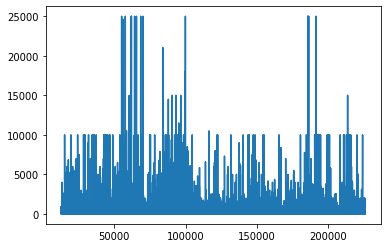

In [ ]:
df['price'].plot();

In [ ]:
df['price'].describe()

count    213518.000000
mean        217.517329
std         562.531513
min           0.000000
25%          75.000000
50%         121.000000
75%         200.000000
max       24999.000000
Name: price, dtype: float64

In [ ]:
df['price'].quantile(0.05)

40.0

In [ ]:
df['price'].quantile(0.95)

595.0

Outlier가 많이 확인되어 상위 5%, 하위 5%의 데이터 삭제 예정 

In [ ]:
df = df[(df['price'] > 40) & (df['price'] <= 595) ]

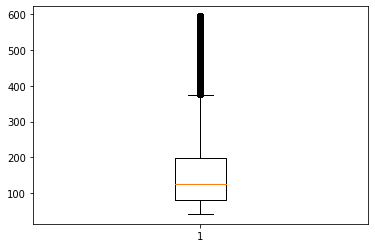

In [ ]:
plt.boxplot(df['price']);

In [ ]:
df.shape

(189996, 16)

##### number_of_reviews

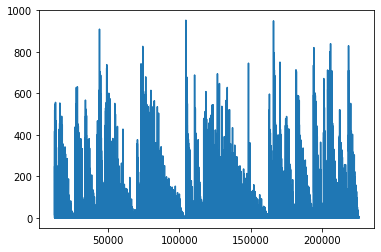

In [ ]:
df['number_of_reviews'].plot();

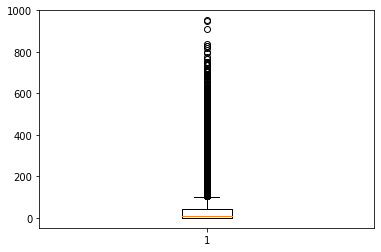

In [ ]:
plt.boxplot(df['number_of_reviews']);

In [ ]:
len(df[df['number_of_reviews'] == 0])

37739

number_of_reviews가 0인 값은 last_review가 결측치 이기 떄문에 삭제 예정

In [ ]:
df['number_of_reviews'].quantile(0.8)

56.0

In [ ]:
df['number_of_reviews'].quantile(0.2)

1.0

0값과 outlier를 제거하기 위해 하위 20%, 상위 20% 제거 

In [ ]:
df = df[(df['number_of_reviews'] > df['number_of_reviews'].quantile(0.2)) & (df['number_of_reviews'] <= df['number_of_reviews'].quantile(0.8)) ]

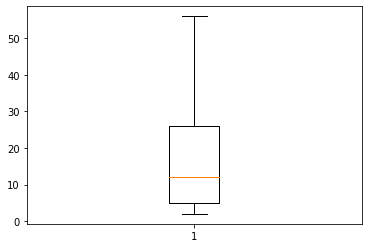

In [ ]:
plt.boxplot(df['number_of_reviews']);

In [ ]:
df['number_of_reviews'].describe()

count    98185.000000
mean        17.122279
std         14.924430
min          2.000000
25%          5.000000
50%         12.000000
75%         26.000000
max         56.000000
Name: number_of_reviews, dtype: float64

In [ ]:
df.shape

(98185, 16)

##### last_review

In [ ]:
df['last_review'] = pd.to_datetime(df['last_review'])

In [ ]:
df['last_review'].isnull().sum()

0

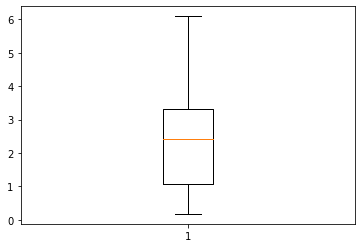

In [ ]:
last = df.sort_values(by='last_review', ascending=False)['reviews_per_month'].head(50)
plt.boxplot(last);

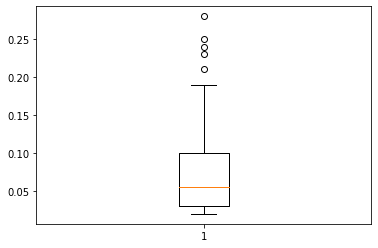

In [ ]:
last_tail = df.sort_values(by='last_review', ascending=False)['reviews_per_month'].tail(50)
plt.boxplot(last_tail);

##### reviews_per_month

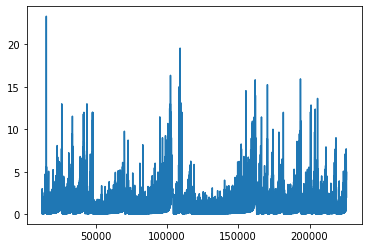

In [ ]:
df['reviews_per_month'].plot();

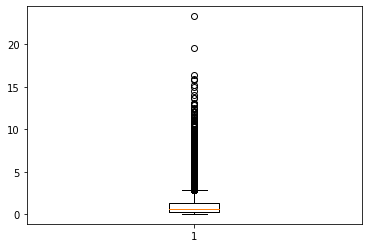

In [ ]:
plt.boxplot(df['reviews_per_month']);

In [ ]:
df['reviews_per_month'].describe()

count    98185.000000
mean         0.940283
std          1.066329
min          0.020000
25%          0.230000
50%          0.570000
75%          1.280000
max         23.330000
Name: reviews_per_month, dtype: float64

In [ ]:
df = df[(df['reviews_per_month'] > df['reviews_per_month'].quantile(0.01)) & (df['reviews_per_month'] <= df['reviews_per_month'].quantile(0.99))]

Outlier 제거를 위해 상위 1%, 하위1% 데이터 제거 

In [ ]:
df['reviews_per_month'].describe()

count    95426.000000
mean         0.900887
std          0.898664
min          0.050000
25%          0.240000
50%          0.570000
75%          1.260000
max          4.900000
Name: reviews_per_month, dtype: float64

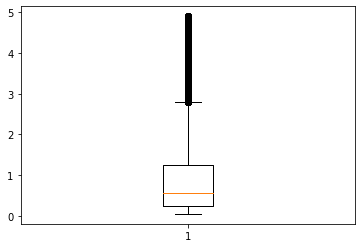

In [ ]:
plt.boxplot(df['reviews_per_month']);

In [ ]:
df.shape

(95426, 16)

##### calculated_host_listings_count

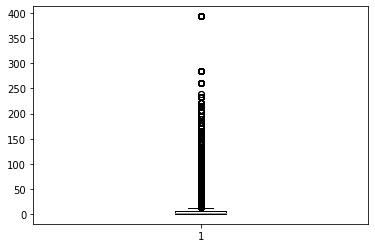

In [ ]:
plt.boxplot(df['calculated_host_listings_count']);

In [ ]:
df['calculated_host_listings_count'].quantile(0.05), df['calculated_host_listings_count'].quantile(0.95)

(1.0, 63.0)

outlier제거 : 상위 5% 데이터 제거 

In [ ]:
df = df[df['calculated_host_listings_count'] <= 63]

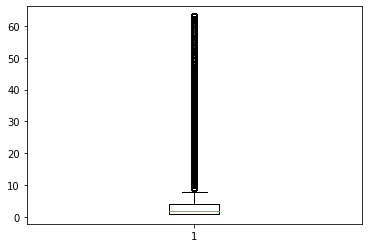

In [ ]:
plt.boxplot(df['calculated_host_listings_count']);

In [ ]:
df.shape

(90782, 16)

##### availability_365

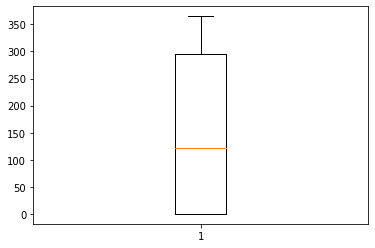

In [ ]:
plt.boxplot(df['availability_365']);

In [ ]:
df['availability_365'].describe()

count    90782.000000
mean       152.091979
std        138.620391
min          0.000000
25%          0.000000
50%        122.000000
75%        296.000000
max        365.000000
Name: availability_365, dtype: float64

In [ ]:
len(df[df['availability_365'] == 0])

24428

availability_365가 0인 경우 : 

1. 예약이 모두 완료됨 

2. 개인사정이나 리모델링 등의 이유로 잠시 휴업 하는 경우 

=> 다양한 경우의 수가 있기 때문에 제거할 예정

In [ ]:
df = df[df['availability_365'] > 0]

In [ ]:
df.shape

(66354, 16)

##### city

In [ ]:
df['city'].value_counts(normalize=True)

New York City        0.174790
Los Angeles          0.152139
Hawaii               0.115080
Broward County       0.069400
San Diego            0.057977
Clark County         0.043615
New Orleans          0.038355
San Clara Country    0.038249
Nashville            0.032251
Chicago              0.032010
San Francisco        0.029719
Seattle              0.027398
Washington D.C.      0.027112
Rhode Island         0.023420
Twin Cities MSA      0.022923
Portland             0.019200
Denver               0.017979
San Mateo County     0.016668
Boston               0.014603
Jersey City          0.013488
Oakland              0.012840
Santa Cruz County    0.008214
Columbus             0.006722
Cambridge            0.004370
Pacific Grove        0.000799
Salem                0.000678
Name: city, dtype: float64

In [ ]:
df.shape

(66354, 16)

#### 3. Feature Engineering

##### popularity

In [ ]:
df['reviews_per_month'].describe()

count    66354.000000
mean         1.034914
std          0.948427
min          0.050000
25%          0.320000
50%          0.720000
75%          1.480000
max          4.900000
Name: reviews_per_month, dtype: float64

In [ ]:
print(df['reviews_per_month'].quantile(0.2))
print(df['reviews_per_month'].quantile(0.4))
print(df['reviews_per_month'].quantile(0.6))
print(df['reviews_per_month'].quantile(0.8))

0.26
0.53
0.95
1.73


In [ ]:
def pop (df) : 
    if df['reviews_per_month'] <= 0.26 : 
        return 1
    elif df['reviews_per_month'] <= 0.53 : 
        return 2 
    elif df['reviews_per_month'] <= 0.95 : 
        return 3 
    elif df['reviews_per_month'] <= 1.73 : 
        return 4 
    else : 
        return 5 

df['popularity'] = df.apply(pop, axis=1)

In [ ]:
df['popularity'].value_counts(normalize=True)

1    0.205172
4    0.201058
5    0.198496
2    0.197953
3    0.197320
Name: popularity, dtype: float64

##### recommend

In [ ]:
def rec (df) : 
    if df['popularity'] == 5 : 
        return 1 
    else : 
        return 0 

df['recommend'] = df.apply(rec, axis=1)

In [ ]:
df['recommend'].value_counts(normalize=True)

0    0.801504
1    0.198496
Name: recommend, dtype: float64

#### 4. EDA

관련없는 column 제거 

In [ ]:
df = df.drop(['id', 'name', 'host_id', 'host_name', 'latitude', 'longitude'], axis=1)

In [ ]:
df.corr()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,popularity,recommend
price,1.000000,-0.046691,-0.039097,-0.077602,0.071133,0.058607,-0.079206,-0.065190
minimum_nights,-0.046691,1.000000,-0.059419,-0.156600,-0.026638,0.064867,-0.179952,-0.108460
number_of_reviews,-0.039097,-0.059419,1.000000,0.486625,-0.099079,-0.024911,0.553333,0.350312
reviews_per_month,-0.077602,-0.156600,0.486625,1.000000,-0.052724,-0.127271,0.869812,0.832862
calculated_host_listings_count,0.071133,-0.026638,-0.099079,-0.052724,1.000000,0.102353,-0.071805,-0.035230
availability_365,0.058607,0.064867,-0.024911,-0.127271,0.102353,1.000000,-0.134944,-0.097717
popularity,-0.079206,-0.179952,0.553333,0.869812,-0.071805,-0.134944,1.000000,0.704999
recommend,-0.065190,-0.108460,0.350312,0.832862,-0.035230,-0.097717,0.704999,1.000000


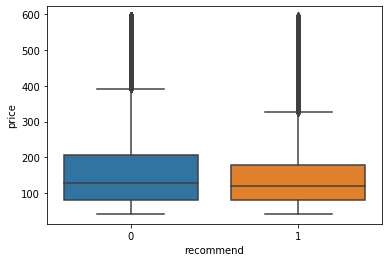

In [ ]:
sns.boxplot(x='recommend', y='price', data=df);

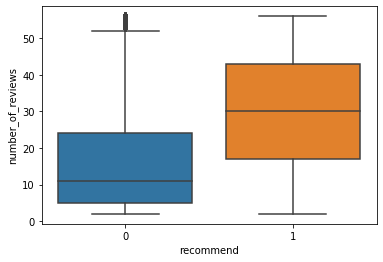

In [ ]:
sns.boxplot(x='recommend', y='number_of_reviews', data=df);

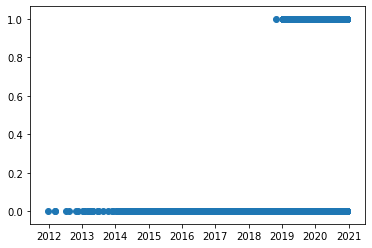

In [ ]:
plt.scatter(x='last_review', y='recommend', data=df);

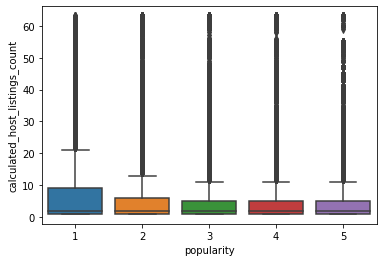

In [ ]:
sns.boxplot(x='popularity', y='calculated_host_listings_count', data=df);

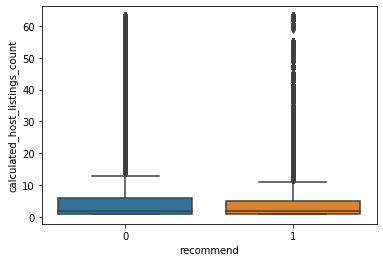

In [ ]:
sns.boxplot(x='recommend', y='calculated_host_listings_count', data=df);

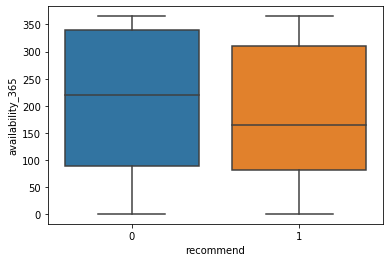

In [ ]:
sns.boxplot(x='recommend', y='availability_365', data=df);

In [ ]:
df['last_review'] = df['last_review'].apply(lambda x: x.toordinal())

#### 가설

Target 설정 가설 : 리뷰가 많으면 인기가 많다. 

1. 가격이 저렴하면 인기가 많을 것이다.
2. 인기가 많을수록 사용가능 날짜가 적을 것이다. (이미 예약 완료)
3. 마지막 리뷰가 최근에 작성된 곳일 수록 인기가 많을 것이다. 
4. 호스트의 숙소수가 많을 수록 인기가 많을 것이다. (전문적 -> 인기↑) => boxplot으로 아님을 알 수 있음 


#### 모델 

In [ ]:
# train, validation, test set 분리 
train, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=2)
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=2)

train.shape, val.shape, test.shape

((42466, 12), (10617, 12), (13271, 12))

In [ ]:
# target, feature 분리 
target = 'recommend'
feature = df.columns.drop(['recommend', 'popularity', 'reviews_per_month']) #data leakage 방지를 위해 제외

# train set
X_train = train[feature]
y_train = train[target]

# validation set 
X_val = val[feature]
y_val = val[target]

# test set 
X_test = test[feature]
y_test = test[target]

In [ ]:
# baseline 설정 
base = y_train.mode()[0]
baseline = [base] * len(y_train)

In [ ]:
# 기준모델 정확도 
print("Train 데이터 기준모델 정확도: ",accuracy_score(y_train, baseline))

Train 데이터 기준모델 정확도:  0.799345358639853


##### Randomforest 모델

In [ ]:
# Randomforest 

pipe_rf = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(random_state=10, n_jobs = -1, oob_score=True)
)

pipe_rf.fit(X_train, y_train);

rf_pred_val = pipe_rf.predict(X_val)

In [ ]:
# Randomforest Validation 데이터 metric

print("Validation 데이터 rf모델 정확도: ",accuracy_score(y_val, rf_pred_val))
print("Validation 데이터 rf모델 precision score: ",precision_score(y_val, rf_pred_val))
print("Validation 데이터 rf모델 recall score: ",recall_score(y_val, rf_pred_val))
print("Validation 데이터 rf모델 f1 score: ",f1_score(y_val, rf_pred_val))

Validation 데이터 rf모델 정확도:  0.8501459922765376
Validation 데이터 rf모델 precision score:  0.6823529411764706
Validation 데이터 rf모델 recall score:  0.44465740297077144
Validation 데이터 rf모델 f1 score:  0.5384392225123296


In [ ]:
#Randomforest hyperparameter 튜닝을 하려고했으나.... 왜인지 성능 저하....튜닝 포기....

##### Xgboost 모델

In [ ]:
# Xgboost 

pipe_x = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier()
)

pipe_x.fit(X_train, y_train);

x_pred_val = pipe_x.predict(X_val) 

In [ ]:
# Xgboost Validation 데이터 metric

print("Validation 데이터 x모델 정확도: ",accuracy_score(y_val, x_pred_val))
print("Validation 데이터 x모델 precision score: ",precision_score(y_val, x_pred_val))
print("Validation 데이터 x모델 recall score: ",recall_score(y_val, x_pred_val))
print("Validation 데이터 x모델 f1 score: ",f1_score(y_val, x_pred_val))

Validation 데이터 x모델 정확도:  0.8479796552698502
Validation 데이터 x모델 precision score:  0.6685673556664291
Validation 데이터 x모델 recall score:  0.4494489698131289
Validation 데이터 x모델 f1 score:  0.5375358166189113


##### Xgboost Hyperparameter 튜닝

In [ ]:
# Xgboost 튜닝 

dist_x = {
        'xgbclassifier__max_depth' : [6, 9],
        'xgbclassifier__n_estimators' : [100, 500],
        'xgbclassifier__learning_rate' : [0.1, 0.3]
        }

clf_x = GridSearchCV(
    pipe_x, 
    param_grid=dist_x,  
    cv=3,
    scoring='precision',
    verbose=1,
    n_jobs = -1
)

clf_x.fit(X_train, y_train);

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  3.5min finished


In [ ]:
print('최적 하이퍼파라미터: ', clf_x.best_params_)
print('precision score: ', clf_x.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 100}
precision score:  0.6753522866022866


##### Xgboost GridSearchCV 모델 - Validation metric 

In [ ]:
pipe_x_g = clf_x.best_estimator_
pipe_x_g.fit(X_train, y_train);

x_g_pred_val = pipe_x_g.predict(X_val)

print("Validation 데이터 x_g모델 정확도    : ",accuracy_score(y_val, x_g_pred_val))
print("Validation 데이터 x_g모델 precision score: ",precision_score(y_val, x_g_pred_val))
print("Validation 데이터 x_g모델 recall score: ",recall_score(y_val, x_g_pred_val))
print("Validation 데이터 x_g모델 f1 score: ",f1_score(y_val, x_g_pred_val))

Validation 데이터 x_g모델 정확도    :  0.8571159461241405
Validation 데이터 x_g모델 precision score:  0.6829268292682927
Validation 데이터 x_g모델 recall score:  0.5098227120268328
Validation 데이터 x_g모델 f1 score:  0.5838134430727023


##### 최종 모델 : pipe_x_g

In [ ]:
y_pred_test = pipe_x_g.predict(X_test)

print("Test 데이터 최종모델 정확도    : ",accuracy_score(y_test, y_pred_test))
print("Test 데이터 최종모델 precision score: ",precision_score (y_test, y_pred_test))
print("Test 데이터 최종모델 recall score: ",recall_score (y_test, y_pred_test))
print("Test 데이터 최종모델 f1 score: ",f1_score (y_test, y_pred_test))

Test 데이터 최종모델 정확도    :  0.8624821038354307
Test 데이터 최종모델 precision score:  0.695859872611465
Test 데이터 최종모델 recall score:  0.5115099492781896
Test 데이터 최종모델 f1 score:  0.5896109736901283


#### 최종 모델 해석

In [ ]:
# permutation importance : 순열 중요도 

enc_X_train = OrdinalEncoder().fit_transform(X_train)

permuter = PermutationImportance(
    pipe_x_g.named_steps['xgbclassifier'], 
    scoring='precision',
    n_iter=5, 
    random_state=2)

permuter.fit(enc_X_train, y_train);

eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=X_train.columns.tolist()
)

Weight,Feature
0.1720 ± 0.0084,number_of_reviews
0.1653 ± 0.0072,last_review
0.1133 ± 0.0132,minimum_nights
0.0447 ± 0.0028,city
0.0378 ± 0.0055,price
0.0325 ± 0.0018,room_type
0.0307 ± 0.0031,availability_365
0.0204 ± 0.0055,neighbourhood
0.0165 ± 0.0017,calculated_host_listings_count


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


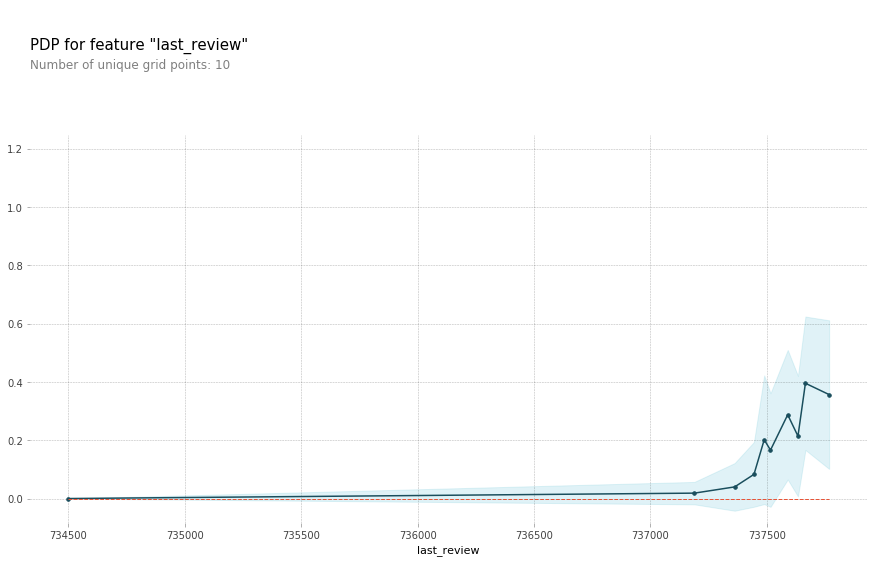

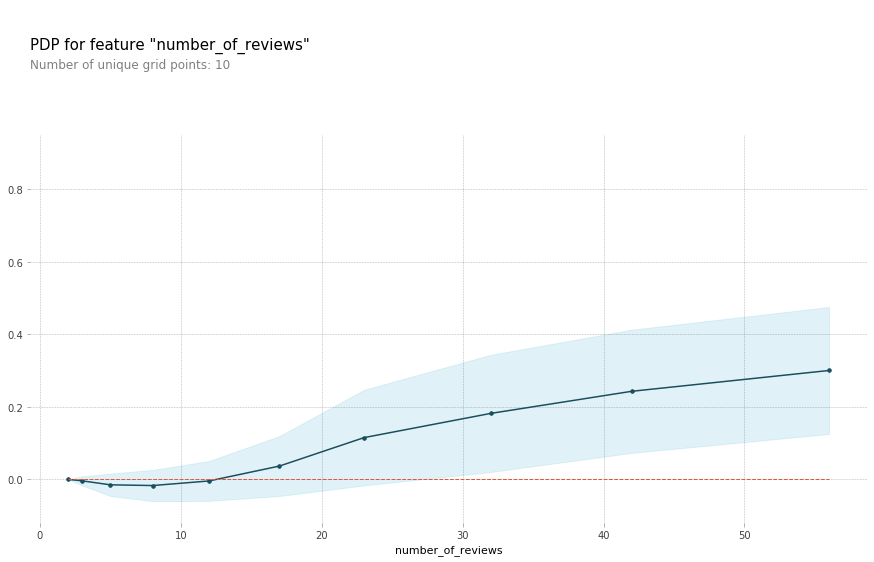

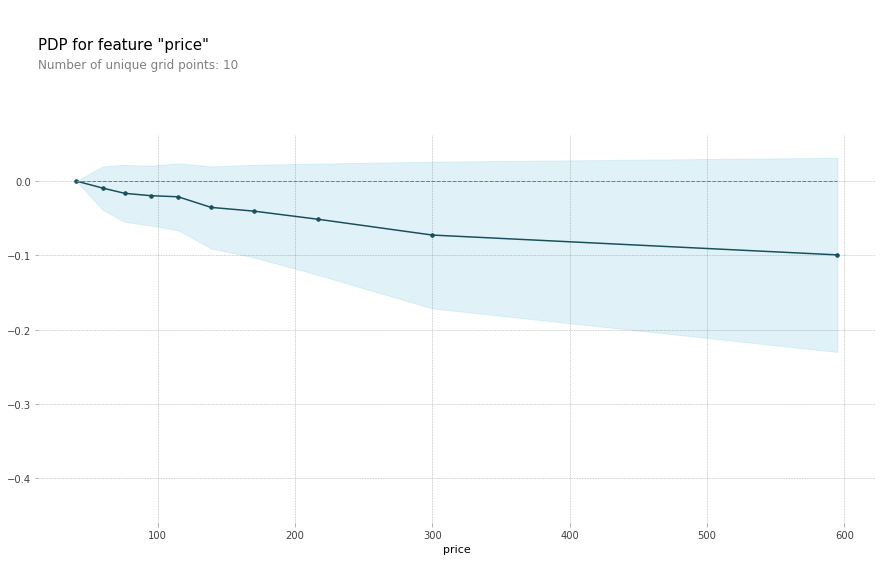

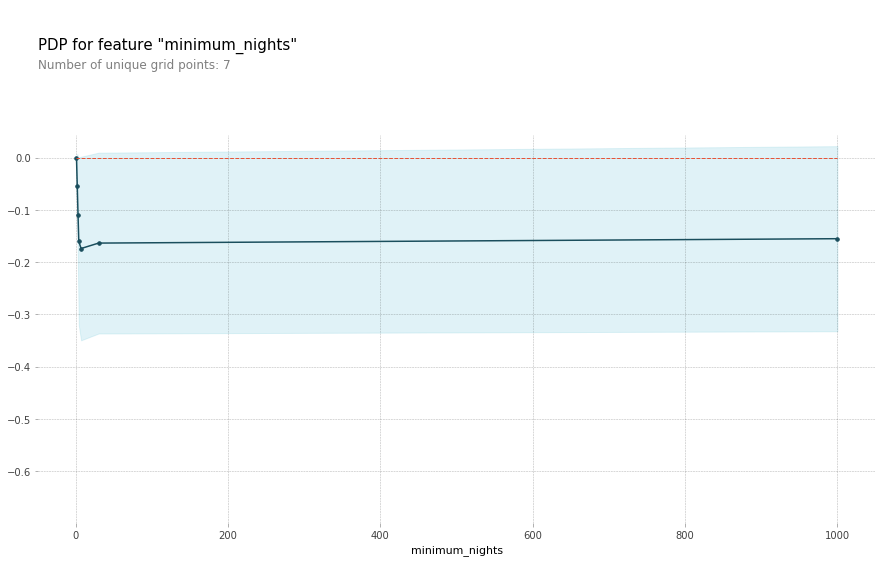

In [ ]:
# PDP : 개별 feature의 영향력 확인 

features = ['last_review', 'number_of_reviews','price','minimum_nights']

for feature in features :
    isolated = pdp_isolate(
        model=pipe_x_g, 
        dataset=X_train, 
        model_features=X_train.columns, 
        feature=feature,
        grid_type='percentile', # default='percentile', or 'equal'
        num_grid_points=10 # default=10
        )
    pdp_plot(isolated, feature_name=feature);

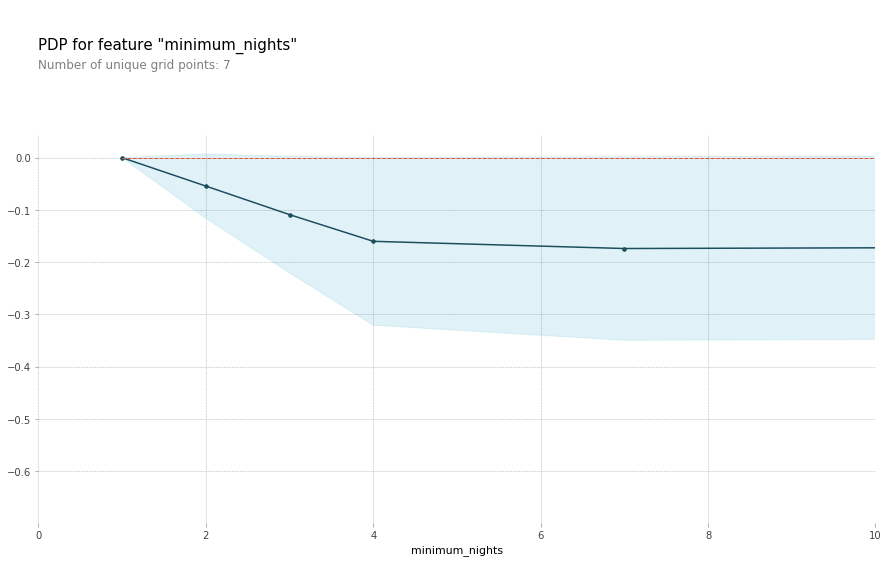

In [ ]:
pdp_plot(isolated, feature_name='minimum_nights')
plt.xlim((0,10));

last_review : 양의 상관관계 

number_of_reviews : 양의 상관관계 

price : 음의 상관관계 

minimum_nights : 음의 상관관계 

In [ ]:
# shap이 pipeline을 지원하지 않기 때문에 단일 모델 생성 

model_x = XGBClassifier(learning_rate = 0.1, max_depth=6, n_estimators=100).fit(enc_X_train, y_train)

In [ ]:
# shap : 전체 feature들의 영향력 확인 

explainer = shap.TreeExplainer(model_x)

shap_values = explainer.shap_values(enc_X_train)

shap.initjs()

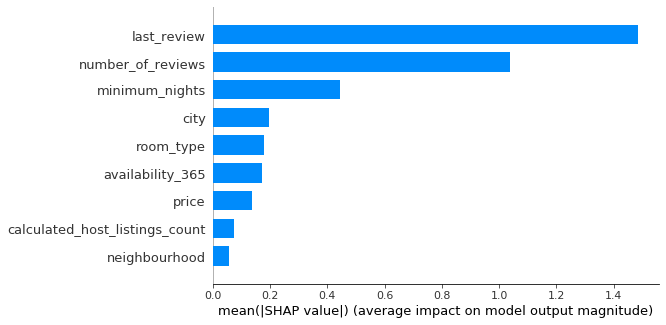

In [ ]:
# summary_plot
# feature들의 전체적인 영향력을 볼 수 있음 (영향력의 방향 상관 없이)

shap.summary_plot(shap_values, enc_X_train, plot_type='bar')

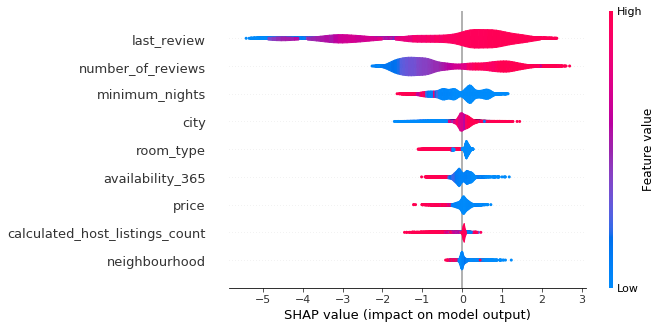

In [ ]:
## summary_plot 
## feature들의 영향력과 방향(Positive/Negative)을 모두 볼 수 있음 

shap.summary_plot(shap_values, enc_X_train, plot_type='violin')